In [ ]:
# BatchNormalization # 데이터 행렬곱 -> 한쪽으로 치우치는 경우가 발생
    - 평균이 0이고 표준편차를 이용해서 정규분포를 다시 생성
    - 신경망 - 정규화
# LeakyReLU : -1 까지 고려
# ReLU : fitting 속도가 빠름 -> 데이터가 적어도 됨 : -를 고려하지 않음
# convolution 연산 : 테두리 때문에 size가 줄어들 수 있으나 전체 사이즈 불변)
# UpSampling2D : pooling시 사이즈가 줄어듬(2,2)

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
if not os.path.exists("./gan_images"): # gan이 생성하는 이미지 저장
    os.makedirs("./gan_images")
np.random.seed(3)
tf.random.set_seed(3)

In [6]:
# 생성기 : noise -> fake image
generator = Sequential()
# noise가 100개의 1차원으로 입력
# (100 , (128*7*7))
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
# 원래 이미지 사이즈가 28x28x1
generator.add(Reshape((7, 7, 128)))# 128 필터적용횟수
generator.add(UpSampling2D())
# 14,14,128
generator.add(Conv2D(64, kernel_size=5, padding='same'))
# 14,14,64
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # 28,28,64
generator.add(Conv2D(1, kernel_size=5, padding='same',activation='tanh')) # 28x28x1 => 이미지 생성

In [7]:
# 판별기
discriminator = Sequential()
# 진짜이미지가 입력 (빈곳은 채우고 2칸씩 건너뛰면서 5x5커널을 적용)
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) #1차원
discriminator.add(Dense(1, activation='sigmoid')) # 0~1사이의 확률값
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # 가중치 수정하지 말라

In [8]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput)) # sigmoide 확률값
gan = Model(ginput, dis_output)
# 분포차를 학습 KLD 발산(divergence)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [13]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data() # test, target
    # 장수 60000
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5 # 정규분포 형태
    true = np.ones((batch_size, 1)) # 판별기 학습 : 진짜는 전부 참
    fake = np.zeros((batch_size, 1)) # 가짜는 전부 거짓
    for i in range(epoch):
        # 32장씩 골라냄
        # 지역해를 방지하기 위해서
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # 실제 이미지는 진짜로 놓고 학습
        d_loss_real = discriminator.train_on_batch(imgs, true)
        # fake를 위한 랜덤수
        noise = np.random.normal(0,1,(batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # 거짓인지 진짜인지 구별하지 못하는 상태 (분포차)
        # 분별기의 loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # fit, train_on_batch
        # pre_trained 모델을 단일 배치로 학습시켜야 할 때
        # 리던값은 loss (scalar)
        g_loss = gan.train_on_batch(noise, true)
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % d_loss)
        if i % saving_interval ==0:
            # 노이즈 25장
            noise = np.random.normal(0,1,(25,100))
            # 생성기에서 노이즈를 통해 실제 이미지를 생성
            gen_imgs = generator.predict(noise)
            gen_imgs = 0.5 * gen_imgs + 0.5
            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5): #25개의 이미지를 생성
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("gan_images/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.3681  g_loss:0.3681
epoch:1  d_loss:0.6242  g_loss:0.6242
epoch:2  d_loss:1.1820  g_loss:1.1820
epoch:3  d_loss:0.9384  g_loss:0.9384
epoch:4  d_loss:0.5523  g_loss:0.5523
epoch:5  d_loss:0.4619  g_loss:0.4619
epoch:6  d_loss:0.5515  g_loss:0.5515
epoch:7  d_loss:0.5358  g_loss:0.5358
epoch:8  d_loss:0.5052  g_loss:0.5052
epoch:9  d_loss:0.4730  g_loss:0.4730
epoch:10  d_loss:0.4418  g_loss:0.4418
epoch:11  d_loss:0.4216  g_loss:0.4216
epoch:12  d_loss:0.4368  g_loss:0.4368
epoch:13  d_loss:0.3614  g_loss:0.3614
epoch:14  d_loss:0.5274  g_loss:0.5274
epoch:15  d_loss:0.4750  g_loss:0.4750
epoch:16  d_loss:0.6414  g_loss:0.6414
epoch:17  d_loss:0.5724  g_loss:0.5724
epoch:18  d_loss:0.6998  g_loss:0.6998
epoch:19  d_loss:0.5603  g_loss:0.5603
epoch:20  d_loss:0.4836  g_loss:0.4836
epoch:21  d_loss:0.4591  g_loss:0.4591
epoch:22  d_loss:0.5367  g_loss:0.5367
epoch:23  d_loss:0.5128  g_loss:0.5128
epoch:24  d_loss:0.5356  g_loss:0.5356
epoch:25  d_loss:0.5190  g_loss:0.5

epoch:208  d_loss:0.4865  g_loss:0.4865
epoch:209  d_loss:0.4581  g_loss:0.4581
epoch:210  d_loss:0.3656  g_loss:0.3656
epoch:211  d_loss:0.4730  g_loss:0.4730
epoch:212  d_loss:0.4818  g_loss:0.4818
epoch:213  d_loss:0.3031  g_loss:0.3031
epoch:214  d_loss:0.4214  g_loss:0.4214
epoch:215  d_loss:0.3626  g_loss:0.3626
epoch:216  d_loss:0.3749  g_loss:0.3749
epoch:217  d_loss:0.3848  g_loss:0.3848
epoch:218  d_loss:0.4245  g_loss:0.4245
epoch:219  d_loss:0.3503  g_loss:0.3503
epoch:220  d_loss:0.4071  g_loss:0.4071
epoch:221  d_loss:0.3766  g_loss:0.3766
epoch:222  d_loss:0.4537  g_loss:0.4537
epoch:223  d_loss:0.3639  g_loss:0.3639
epoch:224  d_loss:0.4311  g_loss:0.4311
epoch:225  d_loss:0.3995  g_loss:0.3995
epoch:226  d_loss:0.5359  g_loss:0.5359
epoch:227  d_loss:0.3342  g_loss:0.3342
epoch:228  d_loss:0.4490  g_loss:0.4490
epoch:229  d_loss:0.4772  g_loss:0.4772
epoch:230  d_loss:0.4322  g_loss:0.4322
epoch:231  d_loss:0.5280  g_loss:0.5280
epoch:232  d_loss:0.4609  g_loss:0.4609


epoch:413  d_loss:0.3532  g_loss:0.3532
epoch:414  d_loss:0.3660  g_loss:0.3660
epoch:415  d_loss:0.3709  g_loss:0.3709
epoch:416  d_loss:0.4781  g_loss:0.4781
epoch:417  d_loss:0.5454  g_loss:0.5454
epoch:418  d_loss:0.3724  g_loss:0.3724
epoch:419  d_loss:0.3570  g_loss:0.3570
epoch:420  d_loss:0.3667  g_loss:0.3667
epoch:421  d_loss:0.4202  g_loss:0.4202
epoch:422  d_loss:0.5776  g_loss:0.5776
epoch:423  d_loss:0.4645  g_loss:0.4645
epoch:424  d_loss:0.4361  g_loss:0.4361
epoch:425  d_loss:0.4856  g_loss:0.4856
epoch:426  d_loss:0.3380  g_loss:0.3380
epoch:427  d_loss:0.3751  g_loss:0.3751
epoch:428  d_loss:0.3397  g_loss:0.3397
epoch:429  d_loss:0.3476  g_loss:0.3476
epoch:430  d_loss:0.6359  g_loss:0.6359
epoch:431  d_loss:0.4242  g_loss:0.4242
epoch:432  d_loss:0.5333  g_loss:0.5333
epoch:433  d_loss:0.2499  g_loss:0.2499
epoch:434  d_loss:0.2989  g_loss:0.2989
epoch:435  d_loss:0.3605  g_loss:0.3605
epoch:436  d_loss:0.3786  g_loss:0.3786
epoch:437  d_loss:0.4641  g_loss:0.4641


epoch:618  d_loss:0.4116  g_loss:0.4116
epoch:619  d_loss:0.2798  g_loss:0.2798
epoch:620  d_loss:0.1834  g_loss:0.1834
epoch:621  d_loss:0.2810  g_loss:0.2810
epoch:622  d_loss:0.3519  g_loss:0.3519
epoch:623  d_loss:0.2030  g_loss:0.2030
epoch:624  d_loss:0.2128  g_loss:0.2128
epoch:625  d_loss:0.2271  g_loss:0.2271
epoch:626  d_loss:0.1245  g_loss:0.1245
epoch:627  d_loss:0.1382  g_loss:0.1382
epoch:628  d_loss:0.3167  g_loss:0.3167
epoch:629  d_loss:0.4354  g_loss:0.4354
epoch:630  d_loss:0.5211  g_loss:0.5211
epoch:631  d_loss:0.5003  g_loss:0.5003
epoch:632  d_loss:0.4030  g_loss:0.4030
epoch:633  d_loss:0.2918  g_loss:0.2918
epoch:634  d_loss:0.3795  g_loss:0.3795
epoch:635  d_loss:0.8240  g_loss:0.8240
epoch:636  d_loss:0.6422  g_loss:0.6422
epoch:637  d_loss:0.7781  g_loss:0.7781
epoch:638  d_loss:0.8740  g_loss:0.8740
epoch:639  d_loss:0.7030  g_loss:0.7030
epoch:640  d_loss:0.8913  g_loss:0.8913
epoch:641  d_loss:0.7004  g_loss:0.7004
epoch:642  d_loss:0.7572  g_loss:0.7572


epoch:823  d_loss:0.3385  g_loss:0.3385
epoch:824  d_loss:0.2749  g_loss:0.2749
epoch:825  d_loss:0.3090  g_loss:0.3090
epoch:826  d_loss:0.2794  g_loss:0.2794
epoch:827  d_loss:0.3707  g_loss:0.3707
epoch:828  d_loss:0.4011  g_loss:0.4011
epoch:829  d_loss:0.2657  g_loss:0.2657
epoch:830  d_loss:0.3387  g_loss:0.3387
epoch:831  d_loss:0.2472  g_loss:0.2472
epoch:832  d_loss:0.2218  g_loss:0.2218
epoch:833  d_loss:0.3305  g_loss:0.3305
epoch:834  d_loss:0.3302  g_loss:0.3302
epoch:835  d_loss:0.3052  g_loss:0.3052
epoch:836  d_loss:0.1925  g_loss:0.1925
epoch:837  d_loss:0.4072  g_loss:0.4072
epoch:838  d_loss:0.3600  g_loss:0.3600
epoch:839  d_loss:0.3531  g_loss:0.3531
epoch:840  d_loss:0.2352  g_loss:0.2352
epoch:841  d_loss:0.3608  g_loss:0.3608
epoch:842  d_loss:0.4231  g_loss:0.4231
epoch:843  d_loss:0.3754  g_loss:0.3754
epoch:844  d_loss:0.4956  g_loss:0.4956
epoch:845  d_loss:0.3904  g_loss:0.3904
epoch:846  d_loss:0.5035  g_loss:0.5035
epoch:847  d_loss:0.4553  g_loss:0.4553


epoch:1028  d_loss:0.4304  g_loss:0.4304
epoch:1029  d_loss:0.3798  g_loss:0.3798
epoch:1030  d_loss:0.3287  g_loss:0.3287
epoch:1031  d_loss:0.3860  g_loss:0.3860
epoch:1032  d_loss:0.3074  g_loss:0.3074
epoch:1033  d_loss:0.5180  g_loss:0.5180
epoch:1034  d_loss:0.3957  g_loss:0.3957
epoch:1035  d_loss:0.2727  g_loss:0.2727
epoch:1036  d_loss:0.4093  g_loss:0.4093
epoch:1037  d_loss:0.4391  g_loss:0.4391
epoch:1038  d_loss:0.3574  g_loss:0.3574
epoch:1039  d_loss:0.3951  g_loss:0.3951
epoch:1040  d_loss:0.4595  g_loss:0.4595
epoch:1041  d_loss:0.4251  g_loss:0.4251
epoch:1042  d_loss:0.5761  g_loss:0.5761
epoch:1043  d_loss:0.4604  g_loss:0.4604
epoch:1044  d_loss:0.3261  g_loss:0.3261
epoch:1045  d_loss:0.3956  g_loss:0.3956
epoch:1046  d_loss:0.5710  g_loss:0.5710
epoch:1047  d_loss:0.4214  g_loss:0.4214
epoch:1048  d_loss:0.3605  g_loss:0.3605
epoch:1049  d_loss:0.3752  g_loss:0.3752
epoch:1050  d_loss:0.4880  g_loss:0.4880
epoch:1051  d_loss:0.4700  g_loss:0.4700
epoch:1052  d_lo

epoch:1228  d_loss:0.4335  g_loss:0.4335
epoch:1229  d_loss:0.4436  g_loss:0.4436
epoch:1230  d_loss:0.5706  g_loss:0.5706
epoch:1231  d_loss:0.4968  g_loss:0.4968
epoch:1232  d_loss:0.5805  g_loss:0.5805
epoch:1233  d_loss:0.4909  g_loss:0.4909
epoch:1234  d_loss:0.4039  g_loss:0.4039
epoch:1235  d_loss:0.5250  g_loss:0.5250
epoch:1236  d_loss:0.5685  g_loss:0.5685
epoch:1237  d_loss:0.6228  g_loss:0.6228
epoch:1238  d_loss:0.4251  g_loss:0.4251
epoch:1239  d_loss:0.3992  g_loss:0.3992
epoch:1240  d_loss:0.5180  g_loss:0.5180
epoch:1241  d_loss:0.4983  g_loss:0.4983
epoch:1242  d_loss:0.6766  g_loss:0.6766
epoch:1243  d_loss:0.4529  g_loss:0.4529
epoch:1244  d_loss:0.5845  g_loss:0.5845
epoch:1245  d_loss:0.5197  g_loss:0.5197
epoch:1246  d_loss:0.5725  g_loss:0.5725
epoch:1247  d_loss:0.6265  g_loss:0.6265
epoch:1248  d_loss:0.5303  g_loss:0.5303
epoch:1249  d_loss:0.5231  g_loss:0.5231
epoch:1250  d_loss:0.4855  g_loss:0.4855
epoch:1251  d_loss:0.4686  g_loss:0.4686
epoch:1252  d_lo

epoch:1428  d_loss:0.3468  g_loss:0.3468
epoch:1429  d_loss:0.3235  g_loss:0.3235
epoch:1430  d_loss:0.5526  g_loss:0.5526
epoch:1431  d_loss:0.5139  g_loss:0.5139
epoch:1432  d_loss:0.5308  g_loss:0.5308
epoch:1433  d_loss:0.4146  g_loss:0.4146
epoch:1434  d_loss:0.4910  g_loss:0.4910
epoch:1435  d_loss:0.3945  g_loss:0.3945
epoch:1436  d_loss:0.3903  g_loss:0.3903
epoch:1437  d_loss:0.3341  g_loss:0.3341
epoch:1438  d_loss:0.5035  g_loss:0.5035
epoch:1439  d_loss:0.5378  g_loss:0.5378
epoch:1440  d_loss:0.5395  g_loss:0.5395
epoch:1441  d_loss:0.5661  g_loss:0.5661
epoch:1442  d_loss:0.4641  g_loss:0.4641
epoch:1443  d_loss:0.2751  g_loss:0.2751
epoch:1444  d_loss:0.4001  g_loss:0.4001
epoch:1445  d_loss:0.5205  g_loss:0.5205
epoch:1446  d_loss:0.6048  g_loss:0.6048
epoch:1447  d_loss:0.4548  g_loss:0.4548
epoch:1448  d_loss:0.4265  g_loss:0.4265
epoch:1449  d_loss:0.5108  g_loss:0.5108
epoch:1450  d_loss:0.3803  g_loss:0.3803
epoch:1451  d_loss:0.6602  g_loss:0.6602
epoch:1452  d_lo

epoch:1628  d_loss:0.7097  g_loss:0.7097
epoch:1629  d_loss:0.5458  g_loss:0.5458
epoch:1630  d_loss:0.4228  g_loss:0.4228
epoch:1631  d_loss:0.6095  g_loss:0.6095
epoch:1632  d_loss:0.5468  g_loss:0.5468
epoch:1633  d_loss:0.5835  g_loss:0.5835
epoch:1634  d_loss:0.5760  g_loss:0.5760
epoch:1635  d_loss:0.2979  g_loss:0.2979
epoch:1636  d_loss:0.4363  g_loss:0.4363
epoch:1637  d_loss:0.4902  g_loss:0.4902
epoch:1638  d_loss:0.4154  g_loss:0.4154
epoch:1639  d_loss:0.3352  g_loss:0.3352
epoch:1640  d_loss:0.5072  g_loss:0.5072
epoch:1641  d_loss:0.4717  g_loss:0.4717
epoch:1642  d_loss:0.4796  g_loss:0.4796
epoch:1643  d_loss:0.4994  g_loss:0.4994
epoch:1644  d_loss:0.5166  g_loss:0.5166
epoch:1645  d_loss:0.4177  g_loss:0.4177
epoch:1646  d_loss:0.3578  g_loss:0.3578
epoch:1647  d_loss:0.4033  g_loss:0.4033
epoch:1648  d_loss:0.4116  g_loss:0.4116
epoch:1649  d_loss:0.5750  g_loss:0.5750
epoch:1650  d_loss:0.5735  g_loss:0.5735
epoch:1651  d_loss:0.7053  g_loss:0.7053
epoch:1652  d_lo

epoch:1828  d_loss:0.5787  g_loss:0.5787
epoch:1829  d_loss:0.5816  g_loss:0.5816
epoch:1830  d_loss:0.4357  g_loss:0.4357
epoch:1831  d_loss:0.4788  g_loss:0.4788
epoch:1832  d_loss:0.5633  g_loss:0.5633
epoch:1833  d_loss:0.4845  g_loss:0.4845
epoch:1834  d_loss:0.5229  g_loss:0.5229
epoch:1835  d_loss:0.4923  g_loss:0.4923
epoch:1836  d_loss:0.4381  g_loss:0.4381
epoch:1837  d_loss:0.5299  g_loss:0.5299
epoch:1838  d_loss:0.4038  g_loss:0.4038
epoch:1839  d_loss:0.3776  g_loss:0.3776
epoch:1840  d_loss:0.4333  g_loss:0.4333
epoch:1841  d_loss:0.4981  g_loss:0.4981
epoch:1842  d_loss:0.5854  g_loss:0.5854
epoch:1843  d_loss:0.4974  g_loss:0.4974
epoch:1844  d_loss:0.6288  g_loss:0.6288
epoch:1845  d_loss:0.4458  g_loss:0.4458
epoch:1846  d_loss:0.5613  g_loss:0.5613
epoch:1847  d_loss:0.4506  g_loss:0.4506
epoch:1848  d_loss:0.4669  g_loss:0.4669
epoch:1849  d_loss:0.5310  g_loss:0.5310
epoch:1850  d_loss:0.4727  g_loss:0.4727
epoch:1851  d_loss:0.5616  g_loss:0.5616
epoch:1852  d_lo

epoch:2028  d_loss:0.5952  g_loss:0.5952
epoch:2029  d_loss:0.5230  g_loss:0.5230
epoch:2030  d_loss:0.4577  g_loss:0.4577
epoch:2031  d_loss:0.6122  g_loss:0.6122
epoch:2032  d_loss:0.4923  g_loss:0.4923
epoch:2033  d_loss:0.4498  g_loss:0.4498
epoch:2034  d_loss:0.5017  g_loss:0.5017
epoch:2035  d_loss:0.6182  g_loss:0.6182
epoch:2036  d_loss:0.4788  g_loss:0.4788
epoch:2037  d_loss:0.5182  g_loss:0.5182
epoch:2038  d_loss:0.5368  g_loss:0.5368
epoch:2039  d_loss:0.4113  g_loss:0.4113
epoch:2040  d_loss:0.4899  g_loss:0.4899
epoch:2041  d_loss:0.6382  g_loss:0.6382
epoch:2042  d_loss:0.5070  g_loss:0.5070
epoch:2043  d_loss:0.5612  g_loss:0.5612
epoch:2044  d_loss:0.4126  g_loss:0.4126
epoch:2045  d_loss:0.5383  g_loss:0.5383
epoch:2046  d_loss:0.4825  g_loss:0.4825
epoch:2047  d_loss:0.5094  g_loss:0.5094
epoch:2048  d_loss:0.5157  g_loss:0.5157
epoch:2049  d_loss:0.4158  g_loss:0.4158
epoch:2050  d_loss:0.4582  g_loss:0.4582
epoch:2051  d_loss:0.5095  g_loss:0.5095
epoch:2052  d_lo

epoch:2228  d_loss:0.4604  g_loss:0.4604
epoch:2229  d_loss:0.6787  g_loss:0.6787
epoch:2230  d_loss:0.3260  g_loss:0.3260
epoch:2231  d_loss:0.5055  g_loss:0.5055
epoch:2232  d_loss:0.5128  g_loss:0.5128
epoch:2233  d_loss:0.4568  g_loss:0.4568
epoch:2234  d_loss:0.4676  g_loss:0.4676
epoch:2235  d_loss:0.5774  g_loss:0.5774
epoch:2236  d_loss:0.4822  g_loss:0.4822
epoch:2237  d_loss:0.5461  g_loss:0.5461
epoch:2238  d_loss:0.5291  g_loss:0.5291
epoch:2239  d_loss:0.5596  g_loss:0.5596
epoch:2240  d_loss:0.4764  g_loss:0.4764
epoch:2241  d_loss:0.5509  g_loss:0.5509
epoch:2242  d_loss:0.5220  g_loss:0.5220
epoch:2243  d_loss:0.5130  g_loss:0.5130
epoch:2244  d_loss:0.4318  g_loss:0.4318
epoch:2245  d_loss:0.5925  g_loss:0.5925
epoch:2246  d_loss:0.6205  g_loss:0.6205
epoch:2247  d_loss:0.4155  g_loss:0.4155
epoch:2248  d_loss:0.5450  g_loss:0.5450
epoch:2249  d_loss:0.6741  g_loss:0.6741
epoch:2250  d_loss:0.5728  g_loss:0.5728
epoch:2251  d_loss:0.6172  g_loss:0.6172
epoch:2252  d_lo

epoch:2428  d_loss:0.4925  g_loss:0.4925
epoch:2429  d_loss:0.5666  g_loss:0.5666
epoch:2430  d_loss:0.5534  g_loss:0.5534
epoch:2431  d_loss:0.5490  g_loss:0.5490
epoch:2432  d_loss:0.5270  g_loss:0.5270
epoch:2433  d_loss:0.5089  g_loss:0.5089
epoch:2434  d_loss:0.4575  g_loss:0.4575
epoch:2435  d_loss:0.6136  g_loss:0.6136
epoch:2436  d_loss:0.5739  g_loss:0.5739
epoch:2437  d_loss:0.5265  g_loss:0.5265
epoch:2438  d_loss:0.5328  g_loss:0.5328
epoch:2439  d_loss:0.6196  g_loss:0.6196
epoch:2440  d_loss:0.6295  g_loss:0.6295
epoch:2441  d_loss:0.5575  g_loss:0.5575
epoch:2442  d_loss:0.4742  g_loss:0.4742
epoch:2443  d_loss:0.5164  g_loss:0.5164
epoch:2444  d_loss:0.5862  g_loss:0.5862
epoch:2445  d_loss:0.5109  g_loss:0.5109
epoch:2446  d_loss:0.5058  g_loss:0.5058
epoch:2447  d_loss:0.5170  g_loss:0.5170
epoch:2448  d_loss:0.6847  g_loss:0.6847
epoch:2449  d_loss:0.5176  g_loss:0.5176
epoch:2450  d_loss:0.6674  g_loss:0.6674
epoch:2451  d_loss:0.7113  g_loss:0.7113
epoch:2452  d_lo

epoch:2628  d_loss:0.5033  g_loss:0.5033
epoch:2629  d_loss:0.5264  g_loss:0.5264
epoch:2630  d_loss:0.4398  g_loss:0.4398
epoch:2631  d_loss:0.4743  g_loss:0.4743
epoch:2632  d_loss:0.5562  g_loss:0.5562
epoch:2633  d_loss:0.6213  g_loss:0.6213
epoch:2634  d_loss:0.5243  g_loss:0.5243
epoch:2635  d_loss:0.5459  g_loss:0.5459
epoch:2636  d_loss:0.6033  g_loss:0.6033
epoch:2637  d_loss:0.6969  g_loss:0.6969
epoch:2638  d_loss:0.4592  g_loss:0.4592
epoch:2639  d_loss:0.4910  g_loss:0.4910
epoch:2640  d_loss:0.4820  g_loss:0.4820
epoch:2641  d_loss:0.5695  g_loss:0.5695
epoch:2642  d_loss:0.5208  g_loss:0.5208
epoch:2643  d_loss:0.6082  g_loss:0.6082
epoch:2644  d_loss:0.4847  g_loss:0.4847
epoch:2645  d_loss:0.6294  g_loss:0.6294
epoch:2646  d_loss:0.7271  g_loss:0.7271
epoch:2647  d_loss:0.4281  g_loss:0.4281
epoch:2648  d_loss:0.4989  g_loss:0.4989
epoch:2649  d_loss:0.4773  g_loss:0.4773
epoch:2650  d_loss:0.5165  g_loss:0.5165
epoch:2651  d_loss:0.3851  g_loss:0.3851
epoch:2652  d_lo

epoch:2828  d_loss:0.4783  g_loss:0.4783
epoch:2829  d_loss:0.5497  g_loss:0.5497
epoch:2830  d_loss:0.6186  g_loss:0.6186
epoch:2831  d_loss:0.6912  g_loss:0.6912
epoch:2832  d_loss:0.7927  g_loss:0.7927
epoch:2833  d_loss:0.5887  g_loss:0.5887
epoch:2834  d_loss:0.5269  g_loss:0.5269
epoch:2835  d_loss:0.4975  g_loss:0.4975
epoch:2836  d_loss:0.5224  g_loss:0.5224
epoch:2837  d_loss:0.7029  g_loss:0.7029
epoch:2838  d_loss:0.5283  g_loss:0.5283
epoch:2839  d_loss:0.5836  g_loss:0.5836
epoch:2840  d_loss:0.4028  g_loss:0.4028
epoch:2841  d_loss:0.5758  g_loss:0.5758
epoch:2842  d_loss:0.4769  g_loss:0.4769
epoch:2843  d_loss:0.5273  g_loss:0.5273
epoch:2844  d_loss:0.4563  g_loss:0.4563
epoch:2845  d_loss:0.5817  g_loss:0.5817
epoch:2846  d_loss:0.5183  g_loss:0.5183
epoch:2847  d_loss:0.6163  g_loss:0.6163
epoch:2848  d_loss:0.6583  g_loss:0.6583
epoch:2849  d_loss:0.5145  g_loss:0.5145
epoch:2850  d_loss:0.3630  g_loss:0.3630
epoch:2851  d_loss:0.6188  g_loss:0.6188
epoch:2852  d_lo

epoch:3028  d_loss:0.5303  g_loss:0.5303
epoch:3029  d_loss:0.4961  g_loss:0.4961
epoch:3030  d_loss:0.4758  g_loss:0.4758
epoch:3031  d_loss:0.5140  g_loss:0.5140
epoch:3032  d_loss:0.5525  g_loss:0.5525
epoch:3033  d_loss:0.5521  g_loss:0.5521
epoch:3034  d_loss:0.5774  g_loss:0.5774
epoch:3035  d_loss:0.5584  g_loss:0.5584
epoch:3036  d_loss:0.4494  g_loss:0.4494
epoch:3037  d_loss:0.6427  g_loss:0.6427
epoch:3038  d_loss:0.4180  g_loss:0.4180
epoch:3039  d_loss:0.5025  g_loss:0.5025
epoch:3040  d_loss:0.5570  g_loss:0.5570
epoch:3041  d_loss:0.5737  g_loss:0.5737
epoch:3042  d_loss:0.4896  g_loss:0.4896
epoch:3043  d_loss:0.6558  g_loss:0.6558
epoch:3044  d_loss:0.5488  g_loss:0.5488
epoch:3045  d_loss:0.4491  g_loss:0.4491
epoch:3046  d_loss:0.5384  g_loss:0.5384
epoch:3047  d_loss:0.6987  g_loss:0.6987
epoch:3048  d_loss:0.5903  g_loss:0.5903
epoch:3049  d_loss:0.6970  g_loss:0.6970
epoch:3050  d_loss:0.4316  g_loss:0.4316
epoch:3051  d_loss:0.5900  g_loss:0.5900
epoch:3052  d_lo

epoch:3228  d_loss:0.5637  g_loss:0.5637
epoch:3229  d_loss:0.5796  g_loss:0.5796
epoch:3230  d_loss:0.5022  g_loss:0.5022
epoch:3231  d_loss:0.5589  g_loss:0.5589
epoch:3232  d_loss:0.4873  g_loss:0.4873
epoch:3233  d_loss:0.4878  g_loss:0.4878
epoch:3234  d_loss:0.5344  g_loss:0.5344
epoch:3235  d_loss:0.5123  g_loss:0.5123
epoch:3236  d_loss:0.6137  g_loss:0.6137
epoch:3237  d_loss:0.4672  g_loss:0.4672
epoch:3238  d_loss:0.4583  g_loss:0.4583
epoch:3239  d_loss:0.4087  g_loss:0.4087
epoch:3240  d_loss:0.5961  g_loss:0.5961
epoch:3241  d_loss:0.6197  g_loss:0.6197
epoch:3242  d_loss:0.4497  g_loss:0.4497
epoch:3243  d_loss:0.4854  g_loss:0.4854
epoch:3244  d_loss:0.4088  g_loss:0.4088
epoch:3245  d_loss:0.5458  g_loss:0.5458
epoch:3246  d_loss:0.4216  g_loss:0.4216
epoch:3247  d_loss:0.4571  g_loss:0.4571
epoch:3248  d_loss:0.5105  g_loss:0.5105
epoch:3249  d_loss:0.6591  g_loss:0.6591
epoch:3250  d_loss:0.4896  g_loss:0.4896
epoch:3251  d_loss:0.4100  g_loss:0.4100
epoch:3252  d_lo

epoch:3428  d_loss:0.5724  g_loss:0.5724
epoch:3429  d_loss:0.4244  g_loss:0.4244
epoch:3430  d_loss:0.5124  g_loss:0.5124
epoch:3431  d_loss:0.4325  g_loss:0.4325
epoch:3432  d_loss:0.4268  g_loss:0.4268
epoch:3433  d_loss:0.3547  g_loss:0.3547
epoch:3434  d_loss:0.3594  g_loss:0.3594
epoch:3435  d_loss:0.4161  g_loss:0.4161
epoch:3436  d_loss:0.4794  g_loss:0.4794
epoch:3437  d_loss:0.4146  g_loss:0.4146
epoch:3438  d_loss:0.3440  g_loss:0.3440
epoch:3439  d_loss:0.4452  g_loss:0.4452
epoch:3440  d_loss:0.4944  g_loss:0.4944
epoch:3441  d_loss:0.5085  g_loss:0.5085
epoch:3442  d_loss:0.4998  g_loss:0.4998
epoch:3443  d_loss:0.3988  g_loss:0.3988
epoch:3444  d_loss:0.5035  g_loss:0.5035
epoch:3445  d_loss:0.4581  g_loss:0.4581
epoch:3446  d_loss:0.4688  g_loss:0.4688
epoch:3447  d_loss:0.7365  g_loss:0.7365
epoch:3448  d_loss:0.5127  g_loss:0.5127
epoch:3449  d_loss:0.5138  g_loss:0.5138
epoch:3450  d_loss:0.5525  g_loss:0.5525
epoch:3451  d_loss:0.4445  g_loss:0.4445
epoch:3452  d_lo

epoch:3628  d_loss:0.4366  g_loss:0.4366
epoch:3629  d_loss:0.5805  g_loss:0.5805
epoch:3630  d_loss:0.5184  g_loss:0.5184
epoch:3631  d_loss:0.3323  g_loss:0.3323
epoch:3632  d_loss:0.5350  g_loss:0.5350
epoch:3633  d_loss:0.5123  g_loss:0.5123
epoch:3634  d_loss:0.5484  g_loss:0.5484
epoch:3635  d_loss:0.4778  g_loss:0.4778
epoch:3636  d_loss:0.5807  g_loss:0.5807
epoch:3637  d_loss:0.4625  g_loss:0.4625
epoch:3638  d_loss:0.3392  g_loss:0.3392
epoch:3639  d_loss:0.5180  g_loss:0.5180
epoch:3640  d_loss:0.3524  g_loss:0.3524
epoch:3641  d_loss:0.3261  g_loss:0.3261
epoch:3642  d_loss:0.5590  g_loss:0.5590
epoch:3643  d_loss:0.5124  g_loss:0.5124
epoch:3644  d_loss:0.4211  g_loss:0.4211
epoch:3645  d_loss:0.5356  g_loss:0.5356
epoch:3646  d_loss:0.6013  g_loss:0.6013
epoch:3647  d_loss:0.4511  g_loss:0.4511
epoch:3648  d_loss:0.5179  g_loss:0.5179
epoch:3649  d_loss:0.3052  g_loss:0.3052
epoch:3650  d_loss:0.4371  g_loss:0.4371
epoch:3651  d_loss:0.5655  g_loss:0.5655
epoch:3652  d_lo

epoch:3828  d_loss:0.5044  g_loss:0.5044
epoch:3829  d_loss:0.5140  g_loss:0.5140
epoch:3830  d_loss:0.3318  g_loss:0.3318
epoch:3831  d_loss:0.3887  g_loss:0.3887
epoch:3832  d_loss:0.3374  g_loss:0.3374
epoch:3833  d_loss:0.5402  g_loss:0.5402
epoch:3834  d_loss:0.5025  g_loss:0.5025
epoch:3835  d_loss:0.4033  g_loss:0.4033
epoch:3836  d_loss:0.5340  g_loss:0.5340
epoch:3837  d_loss:0.5253  g_loss:0.5253
epoch:3838  d_loss:0.4353  g_loss:0.4353
epoch:3839  d_loss:0.3740  g_loss:0.3740
epoch:3840  d_loss:0.3500  g_loss:0.3500
epoch:3841  d_loss:0.4538  g_loss:0.4538
epoch:3842  d_loss:0.4240  g_loss:0.4240
epoch:3843  d_loss:0.4463  g_loss:0.4463
epoch:3844  d_loss:0.4926  g_loss:0.4926
epoch:3845  d_loss:0.5162  g_loss:0.5162
epoch:3846  d_loss:0.5520  g_loss:0.5520
epoch:3847  d_loss:0.5804  g_loss:0.5804
epoch:3848  d_loss:0.4529  g_loss:0.4529
epoch:3849  d_loss:0.5505  g_loss:0.5505
epoch:3850  d_loss:0.6868  g_loss:0.6868
epoch:3851  d_loss:0.4790  g_loss:0.4790
epoch:3852  d_lo

<ipython-input-13-05ad6a7152aa>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


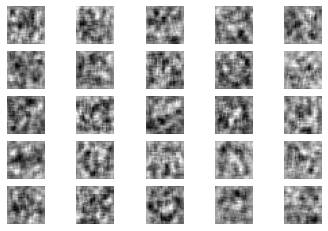

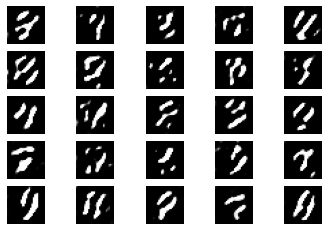

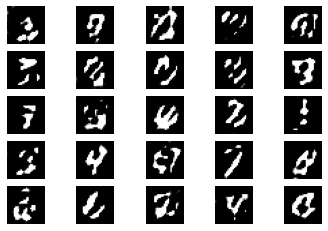

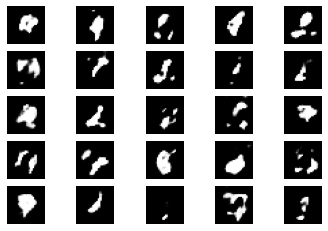

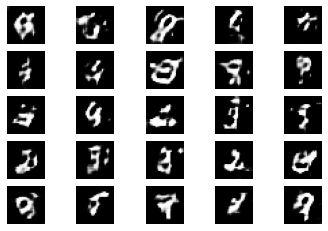

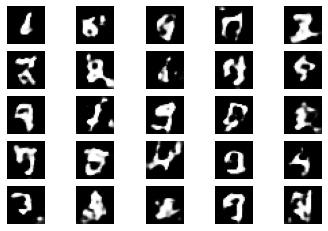

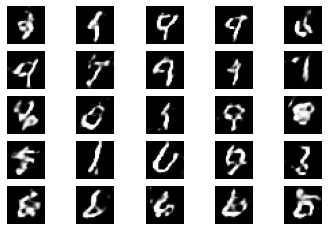

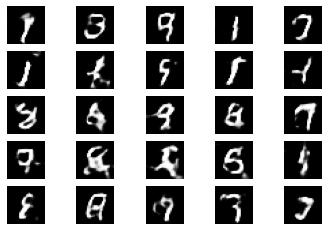

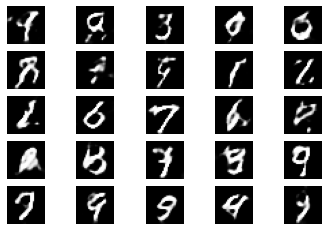

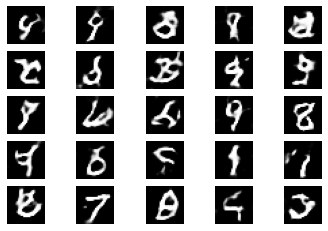

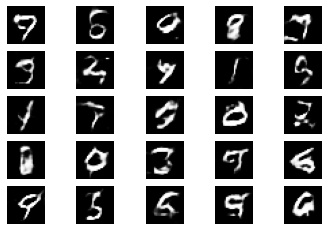

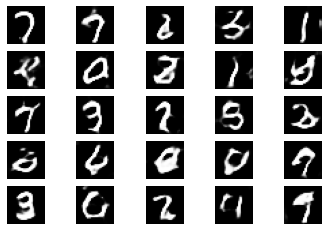

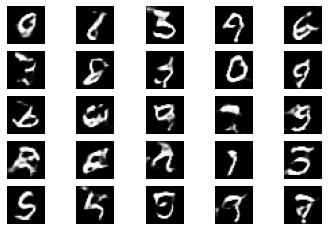

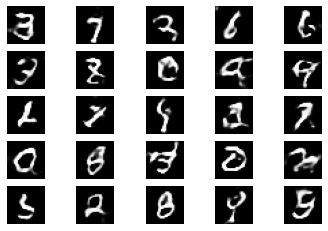

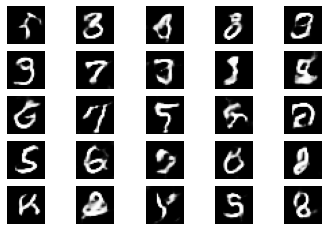

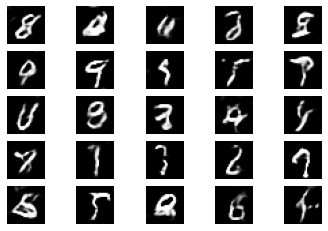

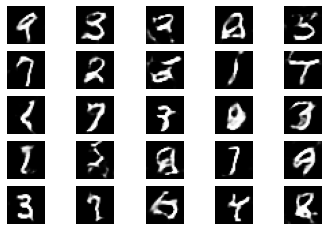

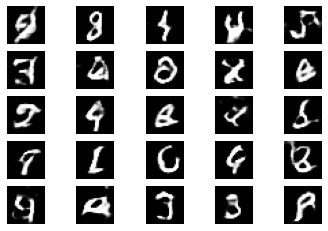

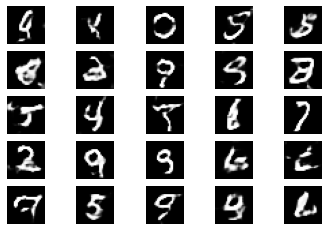

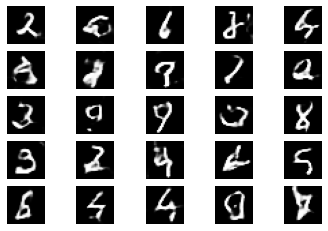

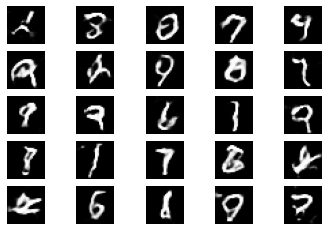

In [14]:
gan_train(4001,32,200)

# AE의 역할
- 차원축소
- 데이터 압축
- 사전 노이즈 제거
- VAE (variational auto encoder) : 생성모델
    - noise를 입력 (분포를 학습)
- abnormal detection (이상 탐지)
    - 보안 공격
    - AE를 통과하고 재구축하는 과정에서 mse가 증가하면 -> 이상이 있음
- denoising : 이미지 + 입력할 때 noise
    - 진짜 noise가 있는 이미지를 입력하면 noise를 제거

In [16]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [17]:
# 특징 축소 : encoding : noise 제거 : 패턴으로 추출되지 않으면
autoencoder = Sequential()
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))
# 차원숙소된 데이터를 이용해서 시각화 (2~3개의 데이터를 이용)
# PCA : 고유값 분해

In [20]:
# decoding
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
# 1장의 이미지로 복원 : 처음 이미자와 상이 : 노이즈 제거
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 8)          

Epoch 1/50
469/469 [==============================] - 38s 80ms/step - loss: 0.2260 - val_loss: 0.1496
Epoch 2/50
469/469 [==============================] - 38s 80ms/step - loss: 0.1357 - val_loss: 0.1242
Epoch 3/50
469/469 [==============================] - 37s 80ms/step - loss: 0.1205 - val_loss: 0.1145
Epoch 4/50
469/469 [==============================] - 38s 81ms/step - loss: 0.1129 - val_loss: 0.1089
Epoch 5/50
469/469 [==============================] - 38s 81ms/step - loss: 0.1084 - val_loss: 0.1054
Epoch 6/50
469/469 [==============================] - 38s 81ms/step - loss: 0.1053 - val_loss: 0.1034
Epoch 7/50
469/469 [==============================] - 38s 81ms/step - loss: 0.1029 - val_loss: 0.1006
Epoch 8/50
469/469 [==============================] - 37s 80ms/step - loss: 0.1012 - val_loss: 0.0990
Epoch 9/50
469/469 [==============================] - 38s 80ms/step - loss: 0.0997 - val_loss: 0.0979
Epoch 10/50
469/469 [==============================] - 38s 81ms/step - loss: 0.098

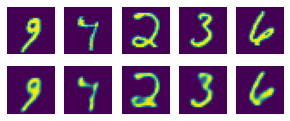

In [21]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))
# 이미지 인덱스
random_test = np.random.randint(X_test.shape[0], size=5)
# --------------------------------------------------------- ----------
ae_imgs = autoencoder.predict(X_test) # 784
plt.figure(figsize=(7,2))
for i, image_idx in enumerate(random_test):
    ax = plt.subplot(2, 7, i + 1) # 14장의 도화지
    plt.imshow(X_test[image_idx].reshape(28, 28)) # 이미지로 출력
    ax.axis('off')
    ax = plt.subplot(2, 7, 7+i+1)
    plt.imshow(ae_imgs[image_idx].reshape(28,28))
    ax.axis('off')
plt.show()